## Human mobility and social connectivity analysis

### Set up

In [ ]:
from tqdm import tqdm
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import reverse_geocoder as rg
from sklearn.metrics.pairwise import cosine_similarity
import ot as pot
import scipy
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import jensenshannon
from scipy.stats import spearmanr

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score


In [ ]:
G = nx.read_edgelist("loc-gowalla_edges.txt", nodetype=int)

In [ ]:
checkins = pd.read_csv("loc-gowalla_totalCheckins.txt", sep="\t", header=None)
checkins.columns = ["user",	"time", "lat", "lon", "location_id"]
checkins["time"] = pd.to_datetime(checkins["time"])
checkins = checkins[(checkins['lat'] >= -90) & (checkins['lat'] <= 90)]
checkins = checkins[(checkins['lon'] >= -180) & (checkins['lon'] <= 180)]
checkins.reset_index(drop=True, inplace=True)
checkins.head()

,user,time,lat,lon,location_id
0,0,2010-10-19 23:55:27+00:00,30.235909,-97.795140,22847
1,0,2010-10-18 22:17:43+00:00,30.269103,-97.749395,420315
2,0,2010-10-17 23:42:03+00:00,30.255731,-97.763386,316637
3,0,2010-10-17 19:26:05+00:00,30.263418,-97.757597,16516
4,0,2010-10-16 18:50:42+00:00,30.274292,-97.740523,5535878


In [ ]:
coords = list(zip(checkins['lat'], checkins['lon']))
results = rg.search(coords)
location_df = pd.DataFrame(results)
checkins = pd.concat([checkins, location_df[["name", "admin1", "admin2", "cc"]]], axis=1)
checkins_fi = checkins[checkins["cc"]=="FI"]

Loading formatted geocoded file...


In [ ]:
finns = []
for u in checkins_fi["user"].unique():
    checkins_u = checkins[checkins["user"]==u]
    if checkins_u["cc"].mode()[0] == "FI":
        finns.append(int(u))

In [ ]:
len(finns)

202

In [ ]:
len(set(checkins_fi["location_id"]))

2376

In [ ]:
checkins_fi = checkins_fi[checkins_fi["user"].isin(finns)]
len(checkins_fi)

7678

In [ ]:
G_fi = G.subgraph(list(finns))
len(G_fi.edges)

260

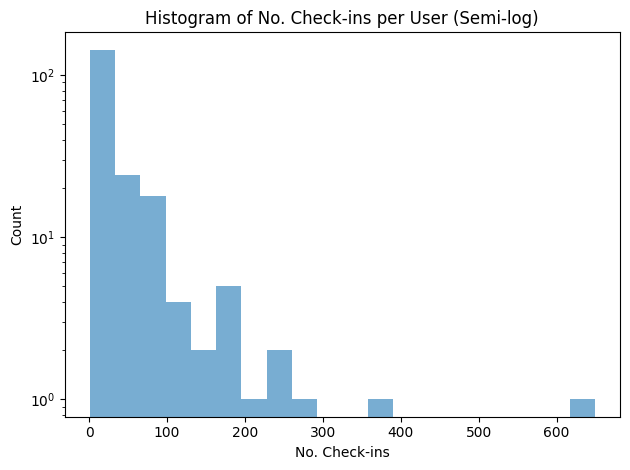

In [ ]:
plt.hist(checkins_fi.groupby("user").size(), bins=20, alpha=0.6)
plt.yscale('log')
plt.xlabel("No. Check-ins")
plt.ylabel("Count")
plt.title("Histogram of No. Check-ins per User (Semi-log)")
plt.tight_layout()
plt.show()


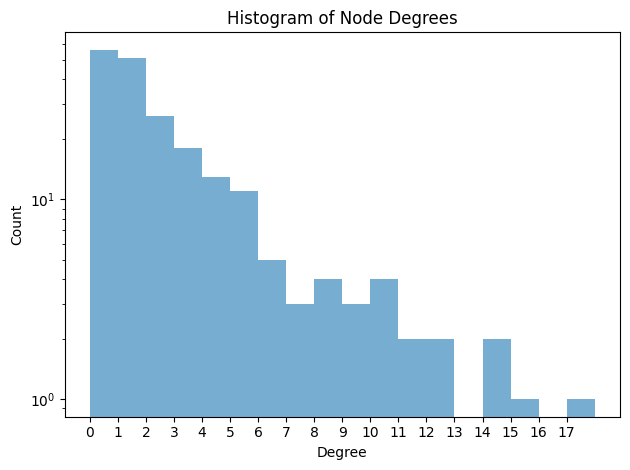

In [ ]:
degrees = [d for n, d in G_fi.degree()]

plt.hist(degrees, bins=range(0, max(degrees) + 2), alpha=0.6)
plt.yscale('log')
plt.xlabel("Degree")
plt.ylabel("Count")
plt.xticks(range(0, max(degrees) + 1))
plt.title("Histogram of Node Degrees")
plt.tight_layout()
plt.show()


100%|██████████| 202/202 [00:00<00:00, 286.82it/s]


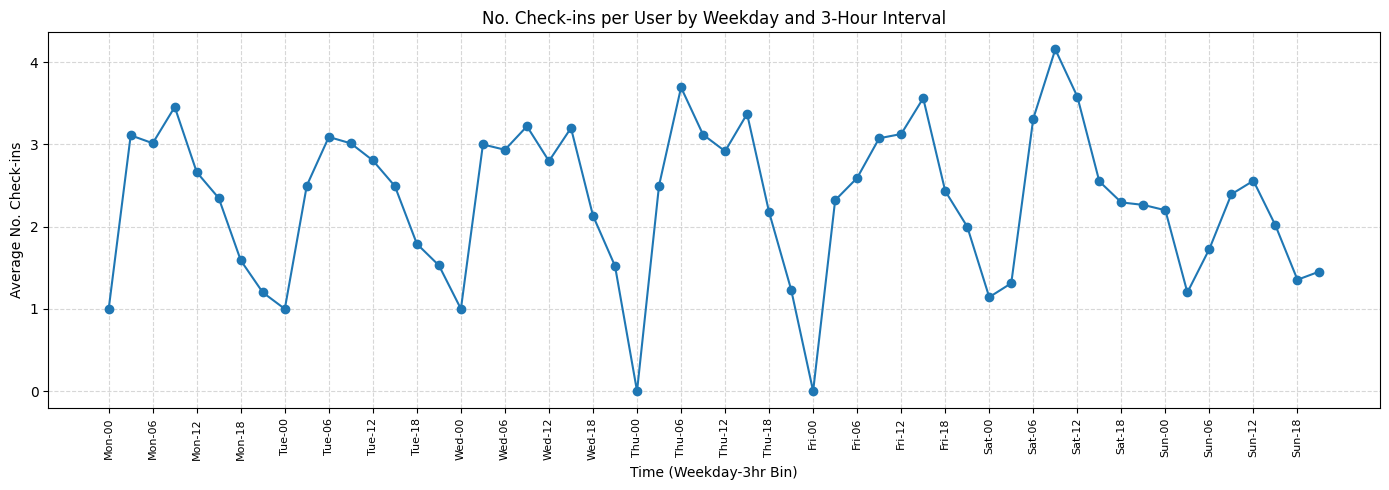

In [ ]:
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
checkin_by_time = {}

for node in tqdm(finns):
    user_checkins = checkins_fi[checkins_fi['user'] == node].copy()
    user_checkins['weekday'] = pd.to_datetime(user_checkins['time']).dt.weekday
    user_checkins['hour_bin'] = pd.to_datetime(user_checkins['time']).dt.hour // 3  # 0–7

    for (wd, bin_id), group in user_checkins.groupby(['weekday', 'hour_bin']):
        key = (wd, bin_id)
        if key not in checkin_by_time:
            checkin_by_time[key] = []
        checkin_by_time[key].append(len(group))

entries = []
for wd in range(7):
    for bin_id in range(8):
        key = (wd, bin_id)
        values = checkin_by_time.get(key, [])
        avg_checkin = np.mean(values) if values else 0.0
        label = f"{day_labels[wd]}-{bin_id * 3:02d}"
        entries.append((wd, bin_id, label, avg_checkin))

entries_sorted = sorted(entries, key=lambda x: (x[0], x[1]))
labels = [e[2] for e in entries_sorted]
avg_checkins = [e[3] for e in entries_sorted]

plt.figure(figsize=(14, 5))
plt.plot(labels, avg_checkins, marker='o', linewidth=1.5)
plt.xticks(ticks=np.arange(0, len(labels), 2), labels=np.array(labels)[::2], rotation=90, fontsize=8)
plt.xlabel('Time (Weekday-3hr Bin)')
plt.ylabel('Average No. Check-ins')
plt.title('No. Check-ins per User by Weekday and 3-Hour Interval')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Measuring the similarities in spatial and temporal check-in patterns between users

In [ ]:
def haversine_matrix(p, q):
    R = 6371000
    p = np.radians(p)
    q = np.radians(q)
    lat1 = p[:, 0][:, np.newaxis]
    lon1 = p[:, 1][:, np.newaxis]
    lat2 = q[:, 0]
    lon2 = q[:, 1]

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [ ]:

def earth_mover_distance_haversine(
    p,
    q,
    eigenvals=None,
    weights1=None,
    weights2=None,
    return_matrix=False,
):
    p = p.toarray() if scipy.sparse.isspmatrix(p) else p
    q = q.toarray() if scipy.sparse.isspmatrix(q) else q

    if eigenvals is not None:
        p = p.dot(eigenvals)
        q = q.dot(eigenvals)

    p_weights = np.ones(len(p)) / len(p) if weights1 is None else weights1.astype("float64") / weights1.sum()
    q_weights = np.ones(len(q)) / len(q) if weights2 is None else weights2.astype("float64") / weights2.sum()

    pairwise_dist = haversine_matrix(p, q)

    result = pot.emd2(
        p_weights, q_weights, pairwise_dist, numItermax=1_000_000, return_matrix=return_matrix
    )

    if return_matrix:
        emd_value, log_dict = result
        return np.sqrt(emd_value), log_dict
    else:
        return np.sqrt(result)


In [ ]:
def earth_mover_distance(
    p,
    q,
    eigenvals=None,
    weights1=None,
    weights2=None,
    return_matrix=False,
    metric="euclidean"
):
    p = p.toarray() if scipy.sparse.isspmatrix(p) else p
    q = q.toarray() if scipy.sparse.isspmatrix(q) else q

    if eigenvals is not None:
        p = p.dot(eigenvals)
        q = q.dot(eigenvals)

    p_weights = np.ones(len(p)) / len(p) if weights1 is None else weights1.astype("float64") / weights1.sum()
    q_weights = np.ones(len(q)) / len(q) if weights2 is None else weights2.astype("float64") / weights2.sum()

    pairwise_dist = np.ascontiguousarray(
        pairwise_distances(p, Y=q, metric=metric, n_jobs=-1)
    )

    result = pot.emd2(
        p_weights, q_weights, pairwise_dist, numItermax=1_000_000, return_matrix=return_matrix
    )

    if return_matrix:
        emd_value, log_dict = result
        return np.sqrt(emd_value), log_dict
    else:
        return np.sqrt(result)


In [ ]:
np.random.seed(0)
random.seed(0)

def calculate_emd(user_a, user_b):
    points_a = checkins_fi[checkins_fi['user'] == user_a][['lat', 'lon']].values
    points_b = checkins_fi[checkins_fi['user'] == user_b][['lat', 'lon']].values
    if len(points_a) == 0 or len(points_b) == 0:
        return np.nan
    return earth_mover_distance_haversine(points_a, points_b)


users = list(G_fi.nodes())
connections = list(G_fi.edges())

def sample_non_edges(G, num_samples, valid_users):
    non_edges = set()
    valid_users = list(valid_users)
    while len(non_edges) < num_samples:
        u, v = random.sample(valid_users, 2)
        if not G_fi.has_edge(u, v) and (u, v) not in non_edges and (v, u) not in non_edges:
            non_edges.add((u, v))
    return list(non_edges)

edges = list(G_fi.edges)
non_edges = sample_non_edges(G_fi, len(edges), finns)

connected_emd = []
for u, v in tqdm(edges, desc="Edges"):
    emd_val = calculate_emd(u, v)
    if not np.isnan(emd_val):
        connected_emd.append(emd_val)

non_connected_emd = []
for u, v in tqdm(non_edges, desc="Non-edges"):
    emd_val = calculate_emd(u, v)
    if not np.isnan(emd_val):
        non_connected_emd.append(emd_val)


Non-edges: 100%|██████████| 260/260 [00:01<00:00, 159.64it/s]


In [ ]:
def encode_time_of_day(timestamps):
    seconds_in_day = 24 * 60 * 60
    seconds = timestamps.dt.hour * 3600 + timestamps.dt.minute * 60 + timestamps.dt.second
    return np.stack([
        np.sin(2 * np.pi * seconds / seconds_in_day),
        np.cos(2 * np.pi * seconds / seconds_in_day)
    ], axis=1)

def encode_weekday(timestamps):
    if not isinstance(timestamps, pd.Series):
        timestamps = pd.Series(timestamps)
    timestamps = pd.to_datetime(timestamps)
    weekday = timestamps.dt.weekday
    counts = weekday.value_counts(sort=False).reindex(range(7), fill_value=0)
    proportions = counts / counts.sum()
    return proportions.values

def calculate_emd_time(user_a, user_b):
    times_a = checkins_fi[checkins_fi['user'] == user_a]['time']
    times_b = checkins_fi[checkins_fi['user'] == user_b]['time']

    if len(times_a) == 0 or len(times_b) == 0:
        return np.nan, np.nan

    tod_a = encode_time_of_day(times_a)
    tod_b = encode_time_of_day(times_b)

    wd_a = encode_weekday(times_a)
    wd_b = encode_weekday(times_b)

    emd_tod = earth_mover_distance(tod_a, tod_b)
    jsd_wd = jensenshannon(wd_a, wd_b)

    return emd_tod, jsd_wd


In [ ]:

connected_emd_tod = []
connected_jsd_wd = []
for u, v in tqdm(edges, desc="Edges"):
    emd_tod, jsd_wd = calculate_emd_time(u, v)
    if not np.isnan(emd_tod):
        connected_emd_tod.append(emd_tod)
    if not np.isnan(jsd_wd):
        connected_jsd_wd.append(jsd_wd)

non_connected_emd_tod = []
non_connected_jsd_wd = []
for u, v in tqdm(non_edges, desc="Non Edges"):
    emd_tod, jsd_wd = calculate_emd_time(u, v)
    if not np.isnan(emd_tod):
        non_connected_emd_tod.append(emd_tod)
    if not np.isnan(jsd_wd):
        non_connected_jsd_wd.append(jsd_wd)


Non Edges: 100%|██████████| 260/260 [00:05<00:00, 45.72it/s]


In [ ]:

def calculate_loc_jaccard_cosine(user_a, user_b):
    locs_a = checkins_fi[checkins_fi['user'] == user_a]['location_id'].value_counts()
    locs_b = checkins_fi[checkins_fi['user'] == user_b]['location_id'].value_counts()

    if len(locs_a) == 0 or len(locs_b) == 0:
        return np.nan, np.nan

    set_a = set(locs_a.index)
    set_b = set(locs_b.index)
    intersection = len(set_a & set_b)
    union = len(set_a | set_b)
    jaccard = intersection / union if union > 0 else np.nan

    shared_locs = list(set_a & set_b)
    if not shared_locs:
        cosine = 0
    else:
        vec_a = np.array([locs_a[loc] for loc in shared_locs], dtype=float).reshape(1, -1)
        vec_b = np.array([locs_b[loc] for loc in shared_locs], dtype=float).reshape(1, -1)
        cosine = cosine_similarity(vec_a, vec_b)[0, 0]

    return 1 - jaccard, 1 - cosine


In [ ]:
connected_jc = []
connected_cosine = []
for u, v in tqdm(edges, desc="Edges"):
    jc, cosine = calculate_loc_jaccard_cosine(u, v)
    if not np.isnan(jc):
        connected_jc.append(jc)
    if not np.isnan(cosine):
        connected_cosine.append(cosine)

non_connected_jc = []
non_connected_cosine = []
for u, v in tqdm(non_edges, desc="Non Edges"):
    jc, cosine = calculate_loc_jaccard_cosine(u, v)
    if not np.isnan(jc):
        non_connected_jc.append(jc)
    if not np.isnan(cosine):
        non_connected_cosine.append(cosine)


Non Edges: 100%|██████████| 260/260 [00:00<00:00, 332.11it/s]


### Comparing the similarity between check-in patterns of connected and unconnected users

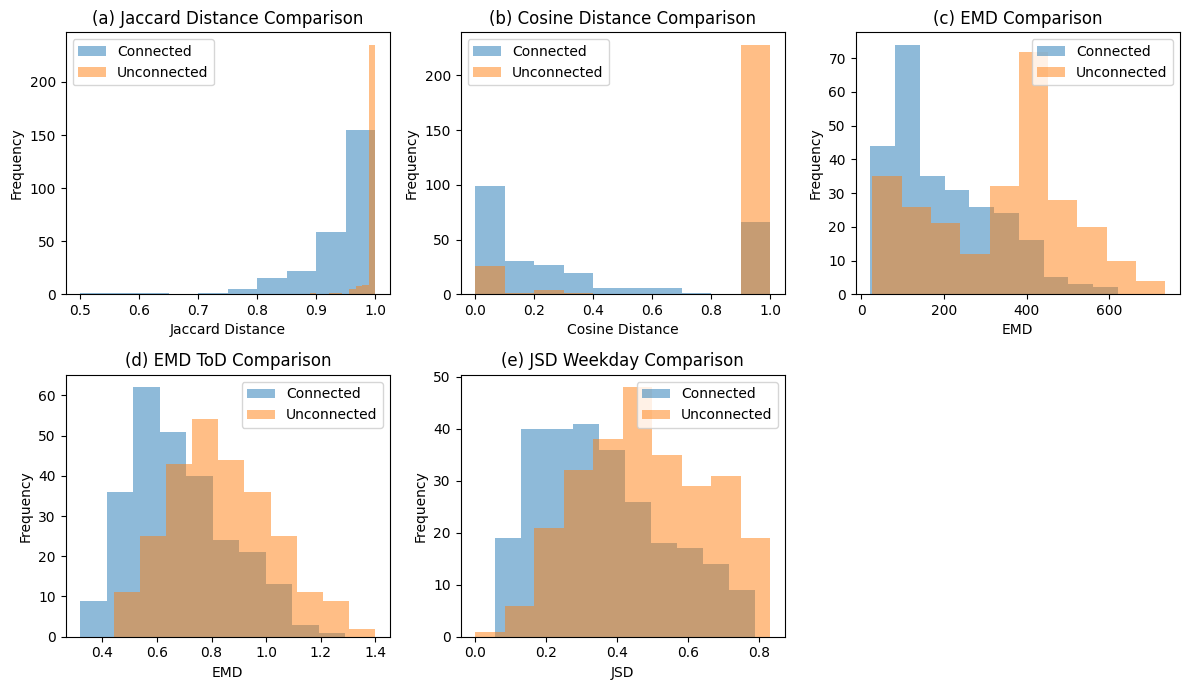

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 7))
axs = axs.flatten()

data = [
    (connected_jc, non_connected_jc, "Jaccard Distance", "Jaccard Distance Comparison"),
    (connected_cosine, non_connected_cosine, "Cosine Distance", "Cosine Distance Comparison"),
    (connected_emd, non_connected_emd, "EMD", "EMD Comparison"),
    (connected_emd_tod, non_connected_emd_tod, "EMD", "EMD ToD Comparison"),
    (connected_jsd_wd, non_connected_jsd_wd, "JSD", "JSD Weekday Comparison")
]

for i, (conn, non_conn, xlabel, title) in enumerate(data):
    axs[i].hist(conn, bins=10, alpha=0.5, label='Connected')
    axs[i].hist(non_conn, bins=10, alpha=0.5, label='Unconnected')
    axs[i].legend()
    axs[i].set_xlabel(xlabel)
    axs[i].set_ylabel("Frequency")
    axs[i].set_title(f"({chr(97+i)}) {title}")  # (a), (b), ...

if len(data) < len(axs):
    fig.delaxes(axs[-1])

plt.tight_layout()
plt.show()


In [ ]:
def permutation_test_mean_difference(group1, group2, n_permutations=1000, alternative='two-sided', seed=None):
    if seed is not None:
        np.random.seed(seed)

    group1 = np.asarray(group1)
    group2 = np.asarray(group2)

    observed_diff = group1.mean() - group2.mean()
    combined = np.concatenate([group1, group2])
    labels = np.array([1]*len(group1) + [0]*len(group2))

    perm_diffs = []
    for _ in range(n_permutations):
        np.random.shuffle(labels)
        perm_group1 = combined[labels == 1]
        perm_group2 = combined[labels == 0]
        diff = perm_group1.mean() - perm_group2.mean()
        perm_diffs.append(diff)

    perm_diffs = np.array(perm_diffs)

    if alternative == 'greater':
        p_val = np.mean(perm_diffs >= observed_diff)
    elif alternative == 'less':
        p_val = np.mean(perm_diffs <= observed_diff)
    else:
        p_val = np.mean(np.abs(perm_diffs) >= np.abs(observed_diff))

    return p_val


In [ ]:

def permutation_spearman_pvalue(x, y, num_permutations=1000, alternative='two-sided'):
    rho_obs, _ = spearmanr(x, y)

    permuted_rhos = []

    for _ in range(num_permutations):
        y_permuted = np.random.permutation(y)
        rho_perm, _ = spearmanr(x, y_permuted)
        permuted_rhos.append(rho_perm)

    permuted_rhos = np.array(permuted_rhos)

    if alternative == 'greater':
        pval = np.mean(permuted_rhos >= rho_obs)
    elif alternative == 'less':
        pval = np.mean(permuted_rhos <= rho_obs)
    else:
        pval = np.mean(np.abs(permuted_rhos) >= np.abs(rho_obs))

    return rho_obs, pval

In [ ]:
np.mean(connected_emd), np.std(connected_emd), np.mean(non_connected_emd), np.std(non_connected_emd)

(np.float64(198.02402800071113),
 np.float64(125.40608732855927),
 np.float64(337.95770334550593),
 np.float64(168.33033376866743))

In [ ]:
np.mean(connected_emd_tod), np.std(connected_emd_tod), np.mean(non_connected_emd_tod), np.std(non_connected_emd_tod)

(np.float64(0.6850997885720682),
 np.float64(0.1793253687438718),
 np.float64(0.8339211890098512),
 np.float64(0.19114660429383745))

In [ ]:
np.mean(connected_jsd_wd), np.std(connected_jsd_wd), np.mean(non_connected_jsd_wd), np.std(non_connected_jsd_wd)

(np.float64(0.3563395836307848),
 np.float64(0.17742978710753496),
 np.float64(0.4805020160722401),
 np.float64(0.18168229937868355))

In [ ]:
np.mean(connected_jc), np.std(connected_jc), np.mean(non_connected_jc), np.std(non_connected_jc)

(np.float64(0.9448375194279429),
 np.float64(0.06824058638796102),
 np.float64(0.9966241807260384),
 np.float64(0.011812529918725263))

In [ ]:
np.mean(connected_cosine), np.std(connected_cosine), np.mean(non_connected_cosine), np.std(non_connected_cosine)

(np.float64(0.3674853931949481),
 np.float64(0.40075737068495954),
 np.float64(0.8833095886427171),
 np.float64(0.3134558093960617))

In [ ]:
permutation_test_mean_difference(connected_emd, non_connected_emd, n_permutations=10000, alternative="less")

np.float64(0.0)

In [ ]:
permutation_test_mean_difference(connected_emd_tod, non_connected_emd_tod, n_permutations=10000, alternative="less")

np.float64(0.0)

In [ ]:
permutation_test_mean_difference(connected_jsd_wd, non_connected_jsd_wd, n_permutations=10000, alternative="less")

np.float64(0.0)

In [ ]:
permutation_test_mean_difference(connected_jc, non_connected_jc, n_permutations=10000, alternative="less")

np.float64(0.0)

In [ ]:
permutation_test_mean_difference(connected_cosine, non_connected_cosine, n_permutations=10000, alternative="less")

np.float64(0.0)

### Link prediction with distance metrics

In [ ]:
connection_df = pd.DataFrame({"edge": edges, "emd": connected_emd, "emd_tod": connected_emd_tod, "jsd_wd": connected_jsd_wd, "jaccard": connected_jc, "cosine": connected_cosine})
connection_df.head()

,edge,emd,emd_tod,jsd_wd,jaccard,cosine
0,"(5645, 29923)",59.653507,0.695522,0.477980,0.960000,0.000000
1,"(114704, 23177)",112.128823,0.556128,0.239253,0.907216,0.187035
2,"(114704, 31010)",75.849573,0.780265,0.292602,0.985294,0.000000
3,"(114704, 43172)",86.112273,0.508491,0.227071,0.876543,0.019109
4,"(114704, 114705)",134.298836,0.660251,0.313398,0.920792,0.267513


In [ ]:
connection_df[["emd", "jaccard", "cosine", "emd_tod", "jsd_wd"]].corr()

,emd,jaccard,cosine,emd_tod,jsd_wd
emd,1.000000,0.298281,0.209508,-0.052857,0.016160
jaccard,0.298281,1.000000,0.350571,0.220193,0.252270
cosine,0.209508,0.350571,1.000000,0.259085,0.293827
emd_tod,-0.052857,0.220193,0.259085,1.000000,0.726806
jsd_wd,0.016160,0.252270,0.293827,0.726806,1.000000


In [ ]:
connected_emd_df = pd.DataFrame({"edges": edges, "emd": connected_emd, "emd_tod": connected_emd_tod, "jsd_wd": connected_jsd_wd, "jaccard": connected_jc, "cosine": connected_cosine})
non_connected_emd_df = pd.DataFrame({"edges": non_edges, "emd": non_connected_emd, "emd_tod": non_connected_emd_tod, "jsd_wd": non_connected_jsd_wd,  "jaccard": non_connected_jc, "cosine": non_connected_cosine})

In [ ]:
link_pred_df = pd.concat([connected_emd_df, non_connected_emd_df]).reset_index(drop=True)
link_pred_df["link"] = [1]*len(connected_emd) + [0]*len(non_connected_emd)

In [ ]:
train_df, test_df = train_test_split(link_pred_df, test_size=0.5, random_state=0, stratify=link_pred_df['link'])

X_train, y_train = train_df[['emd', 'emd_tod', 'jsd_wd', 'jaccard', 'cosine']], train_df['link']
X_test, y_test = test_df[['emd', 'emd_tod', 'jsd_wd', 'jaccard', 'cosine']], test_df['link']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
X, y = link_pred_df[['emd', 'emd_tod', 'jsd_wd', 'jaccard', 'cosine']], link_pred_df['link']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
X_const = sm.add_constant(X_scaled)
model = sm.Logit(y, X_const).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.428175
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                   link   No. Observations:                  520
Model:                          Logit   Df Residuals:                      514
Method:                           MLE   Df Model:                            5
Date:                Sun, 11 May 2025   Pseudo R-squ.:                  0.3823
Time:                        14:56:23   Log-Likelihood:                -222.65
converged:                       True   LL-Null:                       -360.44
Covariance Type:            nonrobust   LLR p-value:                 1.780e-57
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4672      0.194      2.410      0.016       0.087       0.847
x1            -0.5464      0.

In [ ]:
pd.DataFrame(X_scaled, columns=X.columns).corr()

,emd,emd_tod,jsd_wd,jaccard,cosine
emd,1.000000,0.104342,0.126875,0.371044,0.438695
emd_tod,0.104342,1.000000,0.682357,0.305776,0.382622
jsd_wd,0.126875,0.682357,1.000000,0.313205,0.389034
jaccard,0.371044,0.305776,0.313205,1.000000,0.524093
cosine,0.438695,0.382622,0.389034,0.524093,1.000000


In [ ]:
X_train_const = sm.add_constant(X_train_scaled)
pred_model = sm.Logit(y_train, X_train_const).fit()
X_test_const = sm.add_constant(X_test_scaled)
y_pred_prob = pred_model.predict(X_test_const)
y_pred = (y_pred_prob >= 0.5).astype(int)

In [ ]:
roc_auc_score(y_test, y_pred_prob)

np.float64(0.8724852071005917)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.88      0.82       130
           1       0.86      0.72      0.78       130

    accuracy                           0.80       260
   macro avg       0.81      0.80      0.80       260
weighted avg       0.81      0.80      0.80       260



In [ ]:
vif_df = pd.DataFrame({
    "feature": ['const'] + list(X_train.columns),
    "VIF": [variance_inflation_factor(X_train_const, i) for i in range(X_train_const.shape[1])]
})
vif_df

,feature,VIF
0,const,1.000000
1,emd,1.281805
2,emd_tod,1.927220
3,jsd_wd,2.024768
4,jaccard,1.462198
5,cosine,1.638956


### Calculating the proportion of check-ins at locations previously visited by friends 

In [ ]:
def visited_by_neighbor(neighbor_df):
    def fun(checkin):
        if checkin["location_id"] in set(neighbor_df[neighbor_df["time"] < checkin["time"]]["location_id"]):
            return 1
        else:
            return 0
    return fun

p_checkins_visited_by_neighbor = []
for u in tqdm(finns):
    user_checkins = checkins_fi[checkins_fi["user"]==u]
    neighbors = list(G_fi.neighbors(u))
    neighbor_checkins = checkins_fi[checkins_fi["user"].isin(neighbors)]
    visited = user_checkins.apply(visited_by_neighbor(neighbor_checkins), axis=1)
    p_checkins_visited_by_neighbor.append(sum(visited)/len(visited))

100%|██████████| 202/202 [00:05<00:00, 37.19it/s]


Text(0.5, 1.0, 'Histogram of the proportion of check-ins previously visited by friends')

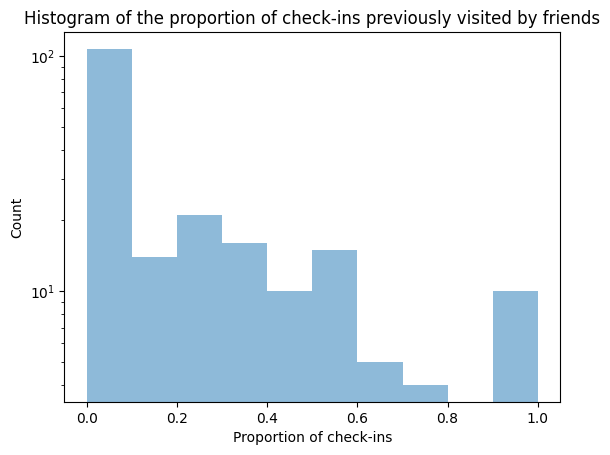

In [ ]:
plt.hist(p_checkins_visited_by_neighbor, alpha=0.5)
plt.xlabel("Proportion of check-ins")
plt.ylabel("Count")
plt.yscale('log')
plt.title("Histogram of the proportion of check-ins previously visited by friends")

### Correlation between influence strength and network metrics

In [ ]:
degrees = dict(G_fi.degree(finns))
clustering = nx.clustering(G_fi, nodes=finns)
betweenness = nx.betweenness_centrality(G_fi)
closeness = nx.closeness_centrality(G_fi)

node_visited_checkins_df = pd.DataFrame({
    "node": finns,
    "degree": [degrees[n] for n in finns],
    "clustering": [clustering[n] for n in finns],
    "betweenness": [betweenness[n] for n in finns],
    "closeness": [closeness[n] for n in finns],
    "p_checkins": p_checkins_visited_by_neighbor
})


In [ ]:
node_visited_checkins_df.head()

,node,degree,clustering,eigenvector,betweenness,closeness,pagerank,p_checkins
0,1847,4,0.000000,0.011748,0.056041,0.178998,0.007705,0.000000
1,2172,2,0.000000,0.001283,0.047910,0.142134,0.005187,0.028571
2,5645,1,0.000000,0.001350,0.000000,0.131782,0.002602,0.000000
3,5823,4,0.333333,0.045303,0.009135,0.184422,0.006234,0.000000
4,7120,2,0.000000,0.005655,0.016600,0.160540,0.003915,0.000000


In [ ]:
X, y = node_visited_checkins_df[['degree', 'clustering', 'betweenness', 'closeness']], node_visited_checkins_df['p_checkins']
epsilon = 1e-6
y = np.log(node_visited_checkins_df['p_checkins'] + epsilon)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
X.corr()

,degree,clustering,betweenness,closeness
degree,1.000000,0.390549,0.656903,0.661468
clustering,0.390549,1.000000,-0.057704,0.332122
betweenness,0.656903,-0.057704,1.000000,0.445803
closeness,0.661468,0.332122,0.445803,1.000000


In [ ]:
X_const = sm.add_constant(pd.DataFrame(X_scaled, columns=X.columns))
model = sm.OLS(y, X_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             p_checkins   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     40.60
Date:                Sun, 11 May 2025   Prob (F-statistic):           8.67e-25
Time:                        23:13:43   Log-Likelihood:                -598.24
No. Observations:                 202   AIC:                             1206.
Df Residuals:                     197   BIC:                             1223.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -7.1464      0.333    -21.447      

In [ ]:
vif_df = pd.DataFrame({
    "feature": ['const'] + list(X.columns),
    "VIF": [variance_inflation_factor(X_const, i) for i in range(X_const.shape[1])]
})
vif_df

,feature,VIF
0,const,1.000000
1,degree,3.167357
2,clustering,1.509758
3,betweenness,2.225884
4,closeness,1.809195


from matplotlib import pyplot as plt
vif_df['VIF'].plot(kind='hist', bins=20, title='VIF')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
vif_df.groupby('feature').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
vif_df['VIF'].plot(kind='line', figsize=(8, 4), title='VIF')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(vif_df['feature'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(vif_df, x='VIF', y='feature', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
permutation_spearman_pvalue(node_visited_checkins_df["degree"], node_visited_checkins_df["p_checkins"])

(np.float64(0.7146795806404315), np.float64(0.0))

In [ ]:
permutation_spearman_pvalue(node_visited_checkins_df["clustering"], node_visited_checkins_df["p_checkins"])

(np.float64(0.5510883556955054), np.float64(0.0))

In [ ]:
permutation_spearman_pvalue(node_visited_checkins_df["betweenness"], node_visited_checkins_df["p_checkins"])

(np.float64(0.4932082260471189), np.float64(0.0))

In [ ]:
permutation_spearman_pvalue(node_visited_checkins_df["closeness"], node_visited_checkins_df["p_checkins"])

(np.float64(0.5446590781586799), np.float64(0.0))